# [ASI Project] Weight Uncertainty in Neural Networks  
**Authors**: Miriam Lamari, Francesco Giannuzzo  


In [228]:
import csv
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from kaggle_secrets import UserSecretsClient
from torch.utils.data import DataLoader, random_split
import wandb

In [229]:
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wandb-api-key')

wandb.login(key=key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Minibatches
**minibatch_weight**(batch_idx: int, num_batches: int)

In [230]:
def minibatch_weight(batch_idx: int, num_batches: int) -> float:
    return 2 ** (num_batches - batch_idx) / (2 ** num_batches - 1)#batch_idx)

## Variational Approximation

In [231]:
from typing import Any, Optional

import torch.nn as nn
from torch import Tensor


class BayesianModule(nn.Module):

    """Base class for BNN to enable certain behaviour."""

    def __init__(self):
        super().__init__()

    def kld(self, *args):
        raise NotImplementedError('BayesianModule::kld()')


def variational_approximator(model: nn.Module) -> nn.Module:

    def kl_divergence(self) -> Tensor:

        kl = 0
        for module in self.modules():
            if isinstance(module, BayesianModule):
                kl += module.kl_divergence

        return kl

    # add `kl_divergence` to the model
    setattr(model, 'kl_divergence', kl_divergence)

    def elbo(self,
             inputs: Tensor,
             targets: Tensor,
             criterion: Any,
             n_samples: int,
             w_complexity: Optional[float] = 1.0) -> Tensor:

        loss = 0
        for sample in range(n_samples):
            outputs = self(inputs)
            loss += criterion(outputs, targets)
            loss += self.kl_divergence() * w_complexity

        return loss / n_samples

    # add `elbo` to the model
    setattr(model, 'elbo', elbo)

    return model


## Scale Mixture Prior

In [232]:
import functools as ft

import torch
import torch.nn as nn
from torch import Tensor


class ScaleMixture(nn.Module):

    """Scale Mixture Prior.

    Section 3.3 of the 'Weight Uncertainty in Neural Networks' paper
    proposes the use of a Scale Mixture prior for use in variational
    inference - this being a fixed-form prior.

    The authors note that, should the parameters be allowed to adjust
    during training, the prior changes rapidly and attempts to capture
    the empirical distribution of the weights. As a result the prior
    learns to fit poor initial parameters and struggles to improve.
    """

    def __init__(self, pi: float, sigma1: float, sigma2: float) -> None:

        """Scale Mixture Prior.

        The authors of 'Weight Uncertainty in Neural Networks' note:

            sigma1 > sigma2:
                provides a heavier tail in the prior density than is
                seen in a plain Gaussian prior.
            sigma2 << 1.0:
                causes many of the weights to a priori tightly
                concentrate around zero.

        Parameters
        ----------
        pi : float
            Parameter used to scale the two Gaussian distributions.
        sigma1 : float
            Standard deviation of the first normal distribution.
        sigma2 : float
            Standard deviation of the second normal distribution.
        """

        super().__init__()

        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.normal1 = torch.distributions.Normal(0, sigma1)
        self.normal2 = torch.distributions.Normal(0, sigma2)

    def log_prior(self, w: Tensor) -> Tensor:

        """Log Likelihood of the weight according to the prior.

        Calculates the log likelihood of the supplied weight given the
        prior distribution - the scale mixture of two Gaussians.

        Parameters
        ----------
        w : Tensor
            Weight to be used to calculate the log likelihood.

        Returns
        -------
        Tensor
            Log likelihood of the weights from the prior distribution.
        """

        likelihood_n1 = torch.exp(self.normal1.log_prob(w))
        likelihood_n2 = torch.exp(self.normal2.log_prob(w))

        p_scalemixture = self.pi * likelihood_n1 + (1 - self.pi) * likelihood_n2
        log_prob = torch.log(p_scalemixture).sum()

        return log_prob

## Gaussian Variational Inference

In [233]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor


class GaussianVariational(nn.Module):
    def __init__(self, mu: Tensor, rho: Tensor) -> None:

        super().__init__()

        self.mu = nn.Parameter(mu)
        self.rho = nn.Parameter(rho)

        self.w = None
        self.sigma = None

        self.normal = torch.distributions.Normal(0, 1)

    def sample(self) -> Tensor:
        device = self.mu.device
        epsilon = self.normal.sample(self.mu.size()).to(device)
        self.sigma = torch.log(1 + torch.exp(self.rho)).to(device)
        self.w = self.mu + self.sigma * epsilon

        return self.w

    def log_posterior(self) -> Tensor:

        if self.w is None:
            raise ValueError('self.w must have a value.')

        log_const = np.log(np.sqrt(2 * np.pi))
        log_exp = ((self.w - self.mu) ** 2) / (2 * self.sigma ** 2)
        log_posterior = -log_const - torch.log(self.sigma) - log_exp

        return log_posterior.sum()

## Bayesian Linear Layer ##

In [234]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor

#from .base_bayesian import BayesianModule
#from .samplers.gaussian_variational import GaussianVariational
#from .samplers.scale_mixture import ScaleMixture


class BayesLinear(BayesianModule):

    """Bayesian Linear Layer.

    Implementation of a Bayesian Linear Layer as described in the
    'Weight Uncertainty in Neural Networks' paper.
    """

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 prior_pi: Optional[float] = 0.5,
                 prior_sigma1: Optional[float] = 1.0,
                 prior_sigma2: Optional[float] = 0.0025) -> None:

        super().__init__()

        w_mu = torch.empty(out_features, in_features).uniform_(-0.2, 0.2)
        w_rho = torch.empty(out_features, in_features).uniform_(-5.0, -4.0)

        bias_mu = torch.empty(out_features).uniform_(-0.2, 0.2)
        bias_rho = torch.empty(out_features).uniform_(-5.0, -4.0)

        self.w_posterior = GaussianVariational(w_mu, w_rho)
        self.bias_posterior = GaussianVariational(bias_mu, bias_rho)

        self.w_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)
        self.bias_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)

        self.kl_divergence = 0.0

    def forward(self, x: Tensor) -> Tensor:

        w = self.w_posterior.sample()
        b = self.bias_posterior.sample()

        w_log_prior = self.w_prior.log_prior(w)
        b_log_prior = self.bias_prior.log_prior(b)

        w_log_posterior = self.w_posterior.log_posterior()
        b_log_posterior = self.bias_posterior.log_posterior()

        total_log_prior = w_log_prior + b_log_prior
        total_log_posterior = w_log_posterior + b_log_posterior
        self.kl_divergence = self.kld(total_log_prior, total_log_posterior)

        return F.linear(x, w, b)

    def kld(self, log_prior: Tensor, log_posterior: Tensor) -> Tensor:
        return log_posterior - log_prior

In [235]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

In [236]:
def train_wrapper():
    run = wandb.init(project="Project-ASI")

    return train_loop(
        learning_rate = wandb.config.learning_rate,
        prior_pi = wandb.config.prior_pi,
        prior_sigma1=wandb.config.prior_sigma1,
        prior_sigma2=wandb.config.prior_sigma2
    )

# Bandits on Mushroom Task

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


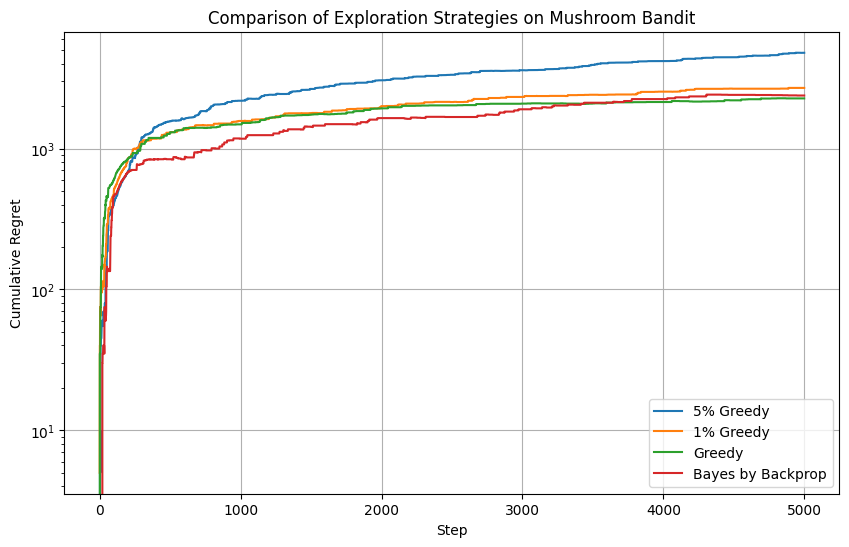

In [237]:
# --- Section: Mushroom Bandit Task (Bayes by Backprop and Greedy Baselines) ---

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load Mushroom Dataset
mushroom_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
                             header=None)
mushroom_data = mushroom_data.replace("?", mushroom_data.mode().iloc[0])

enc = OneHotEncoder(sparse=False)
X = enc.fit_transform(mushroom_data.iloc[:, 1:])
y = (mushroom_data[0] == 'e').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define baseline MLP for greedy agents
class GreedyNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Run agent with epsilon-greedy strategy (Bayesian or not)
def run_agent(model, optimizer, epsilon, is_bayesian=False, max_steps=5000, batch_size=64):
    device = next(model.parameters()).device
    buffer = []
    regret_list = []
    cumulative_regret = []

    for step in range(max_steps):
        idx = np.random.randint(0, X_train.shape[0])
        context = torch.tensor(X_train[idx], dtype=torch.float32).to(device)
        label = y_train[idx]

        actions = torch.eye(2).to(device)
        expected_rewards = []

        for a in actions:
            input_vec = torch.cat([context, a]).unsqueeze(0)
            if is_bayesian:
                out1 = model(input_vec)
                out2 = model(input_vec)
                expected_rewards.append((out1 + out2) / 2)
            else:
                expected_rewards.append(model(input_vec))

        expected_rewards = torch.cat(expected_rewards)

        if random.random() < epsilon:
            action_idx = torch.randint(0, 2, (1,)).item()
        else:
            action_idx = torch.argmax(expected_rewards).item()

        action = action_idx
        if action == 0:
            reward = 5 if label == 1 else (5 if np.random.rand() < 0.5 else -35)
        else:
            reward = 0

        oracle_reward = 5 if label == 1 else 0
        regret = oracle_reward - reward
        regret_list.append(regret)
        cumulative_regret.append(sum(regret_list))

        if step % 5000 == 0 and step > 0:
            print(f"Step {step} | Epsilon {epsilon} | Cumulative regret: {cumulative_regret[-1]:.2f}")

        buffer.append((context.cpu(), torch.eye(2)[action], torch.tensor([reward], dtype=torch.float32)))
        if len(buffer) > 4096:
            buffer.pop(0)

        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            contexts, actions_, rewards = zip(*batch)
            contexts = torch.stack(contexts).to(device)
            actions_ = torch.stack(actions_).to(device)
            rewards = torch.stack(rewards).to(device)
            inputs = torch.cat([contexts, actions_], dim=1)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = F.mse_loss(outputs, rewards.squeeze())
            loss.backward()
            optimizer.step()

    return cumulative_regret

# Run and compare all agents
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train.shape[1]

# Bayes by Backprop
bbb_model = BayesianMushroomNet(input_dim, BayesLinear).to(device)
bbb_opt = torch.optim.Adam(bbb_model.parameters(), lr=1e-3)
regret_bbb = run_agent(bbb_model, bbb_opt, epsilon=0.0, is_bayesian=True)

# Greedy (0%)
greedy_model = GreedyNet(input_dim).to(device)
greedy_opt = torch.optim.Adam(greedy_model.parameters(), lr=1e-3)
regret_0 = run_agent(greedy_model, greedy_opt, epsilon=0.0)

# Greedy (1%)
greedy_model_1 = GreedyNet(input_dim).to(device)
greedy_opt_1 = torch.optim.Adam(greedy_model_1.parameters(), lr=1e-3)
regret_1 = run_agent(greedy_model_1, greedy_opt_1, epsilon=0.01)

# Greedy (5%)
greedy_model_5 = GreedyNet(input_dim).to(device)
greedy_opt_5 = torch.optim.Adam(greedy_model_5.parameters(), lr=1e-3)
regret_5 = run_agent(greedy_model_5, greedy_opt_5, epsilon=0.05)

# Plot all results
plt.figure(figsize=(10, 6))
plt.plot(regret_5, label="5% Greedy")
plt.plot(regret_1, label="1% Greedy")
plt.plot(regret_0, label="Greedy")
plt.plot(regret_bbb, label="Bayes by Backprop")
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Exploration Strategies on Mushroom Bandit")
plt.grid(True)
plt.show()
